# Etudiants : Haumesser Pierrick - MA Marine - PEJOUT Aurelien

# CentraleSupelec - Natural language processing
# Practical session n°7


## Natural Language Inferencing (NLI): 

(NLI) is a classical NLP (Natural Language Processing) problem that involves taking two sentences (the premise and the hypothesis ), and deciding how they are related- if the premise *entails* the hypothesis, *contradicts* it, or *neither*.

Ex: 


| Premise | Label | Hypothesis |
| --- | --- | --- |
| A man inspects the uniform of a figure in some East Asian country. | contradiction | The man is sleeping. |
| An older and younger man smiling. | neutral | Two men are smiling and laughing at the cats playing on the floor. |
| A soccer game with multiple males playing. | entailment | Some men are playing a sport. |

### Stanford NLI (SNLI) corpus

In this labwork, I propose to use the Stanford NLI (SNLI) corpus ( https://nlp.stanford.edu/projects/snli/ ), available in the *Datasets* library by Huggingface.

    from datasets import load_dataset
    snli = load_dataset("snli")
    #Removing sentence pairs with no label (-1)
    snli = snli.filter(lambda example: example['label'] != -1) 

## Subject

You are asked to provide an operational Jupyter notebook that performs the task of NLI. For that, you need to tackle the following aspects of the problem:

1. Loading and preprocessing the data
2. Designing a PyTorch model that, given two sentences, decides how they are related (*entails*, *contradicts* or *neither*.)
3. Training and evaluating the model using appropriate metrics
4. (Optional) Allowing to play with the model (forward user sentences and visualize the prediction easily)
5. (Optional) Providing visual insight about the model (i.e. visualizing the attention if your model is using attention)

Although it is not mandatory, I suggest that you use a transformer model to perform the task. For that, you can use the *Transformer* library by Huggingface.

## Evaluation

The evaluation will be based on several criteria:

- Clarity and readability of the notebook. The notebook is the report of you project. Make it easy and pleasant to read.
- Justification of implementation choices (i.e. the network, the cost funtion, the optimizer, ...)
- Quality of the code. The various deeplearning and NLP labworks provide many example of good practices for designing experiments with neural networks. Use them as inspirational examples!

## Additional recommendations

- You are not seeking to publish a research paper! I'm not expecting state-of-the-art results! The idea of this labwork is to assess that you have integrated the skills necessary to handle textual data using deep neural network techniques.

- This labwork will be evaluated but we are still here to help you! Don't hesitate to request our help if you are stuck.

- If you intend to use BERT based models, let me give you an advice. The bert-base-* models available in *Transformers* need more than 12Go to be fine-tuned on GPU. To avoid memory issues, you can use several solutions: 

    - Use a lighter BERT based model such as DistilBERT, ALBERT, ...
    - Train a classification model on top of BERT, whithout fine-tuning it (i.e. freezing BERT weights)

## Huggingface documentations

In case you want to use the huggingface *Datasets* and *Transformer* libraries (which I advice), here are some useful documentation pages:

- Dataset quick tour

    https://huggingface.co/docs/datasets/quicktour.html
    
- Documentation on data preprocessing for transformers

    https://huggingface.co/transformers/preprocessing.html
    
- Transformer Quick tour (with distilbert example for classification).

    https://huggingface.co/transformers/quicktour.html
    


## Part 0 : Imports

In [1]:
from nltk.tokenize import word_tokenize 
import pandas as pd
import os
from datasets import load_dataset
from transformers import AutoTokenizer, BertForSequenceClassification,AutoModelForSequenceClassification, DistilBertConfig, DistilBertTokenizer, DistilBertForSequenceClassification, BertTokenizer, BertModel,DistilBertModel
import time
import multiprocessing
from tqdm import tqdm
import torch
from torch import nn


## Part 0 bis : Variables

In [2]:
BATCH_SIZE = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-5
epocs = 10

## Part 1 : Load data / tokenizer and preprocess


On télécharge dans un premier temps de data set SNLI

In [3]:
snli = load_dataset("snli")
#Removing sentence pairs with no label (-1)
snli = snli.filter(lambda example: example['label'] != -1)

Reusing dataset snli (/usr/users/gpusdi1/gpusdi1_34/.cache/huggingface/datasets/snli/plain_text/1.0.0/bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec28f298761eb69e5b537c)
Loading cached processed dataset at /usr/users/gpusdi1/gpusdi1_34/.cache/huggingface/datasets/snli/plain_text/1.0.0/bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec28f298761eb69e5b537c/cache-9fd499264a29715c.arrow
Loading cached processed dataset at /usr/users/gpusdi1/gpusdi1_34/.cache/huggingface/datasets/snli/plain_text/1.0.0/bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec28f298761eb69e5b537c/cache-d42e8f7826ad1311.arrow
Loading cached processed dataset at /usr/users/gpusdi1/gpusdi1_34/.cache/huggingface/datasets/snli/plain_text/1.0.0/bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec28f298761eb69e5b537c/cache-c2a8e9801b4a0855.arrow


On visualise le dataset pour mieux comprendre comment celui-ci est construit.

In [4]:
snli

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 9824
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 549367
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 9842
    })
})

Regardons un premier exemple de phrase :

In [5]:
snli['train']['premise'][1]

'A person on a horse jumps over a broken down airplane.'

In [6]:
snli['train']['hypothesis'][1]

'A person is at a diner, ordering an omelette.'

In [7]:
snli['train']['label'][1]

2

In [8]:
train = snli['train']
validation = snli['validation']
test = snli['test']

In [9]:
print(train.shape)
print(validation.shape)
print(test.shape)

(549367, 3)
(9842, 3)
(9824, 3)


Durant ce TP, on se propose d'utiliser un BERT (Bidirectional Encoder Representations from Transformers). Les GPU de l'école n'étant pas assez puissants pour faire tourner ce modèle, on utilise un distilBERT (un modèle plus léger que le BERT initial) que l'on va entrainer pour notre problème.

Ainsi, on aura seulement 3 outputs, représentant le lien entre les deux phrases.

On utilise aussi le tokenizer issu du distilBERT pour transformer nos phrases en un input que le modèle puisse lire.

Dans cette partie, on suit la méthode présentée sur cette page web : https://huggingface.co/docs/datasets/quicktour.html

In [10]:
from transformers import DistilBertConfig, DistilBertTokenizer, DistilBertForSequenceClassification

bertmodel = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",output_attentions=True,num_labels=3)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [11]:
tokenizer

PreTrainedTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

La phrase la plus longue du train set fait 110 mots c'est pour cela que le padding complète jusqu'à 110 mots.
(En utilisant padding=True, on obtient une erreur lors de l'entraînement d'où la synthaxe que l'on a dans la fonction "bert_encode")

In [12]:
def bert_encode(dataset):
    return(tokenizer(dataset['premise'], dataset['hypothesis'], truncation=True, padding='max_length',max_length = 110))

In [13]:
train = train.map(bert_encode, batched=True,batch_size = BATCH_SIZE, num_proc=os.cpu_count())
test = test.map(bert_encode, batched=True,batch_size = BATCH_SIZE,num_proc=os.cpu_count())
validation = validation.map(bert_encode, batch_size = BATCH_SIZE,batched=True,num_proc=os.cpu_count())

Loading cached processed dataset at /usr/users/gpusdi1/gpusdi1_34/.cache/huggingface/datasets/snli/plain_text/1.0.0/bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec28f298761eb69e5b537c/cache-2e9554cba99c566b.arrow
Loading cached processed dataset at /usr/users/gpusdi1/gpusdi1_34/.cache/huggingface/datasets/snli/plain_text/1.0.0/bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec28f298761eb69e5b537c/cache-dba3dd57a689cd9b.arrow
Loading cached processed dataset at /usr/users/gpusdi1/gpusdi1_34/.cache/huggingface/datasets/snli/plain_text/1.0.0/bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec28f298761eb69e5b537c/cache-ff7ffd696d3f55fc.arrow
Loading cached processed dataset at /usr/users/gpusdi1/gpusdi1_34/.cache/huggingface/datasets/snli/plain_text/1.0.0/bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec28f298761eb69e5b537c/cache-d35ff4a1a9284928.arrow
Loading cached processed dataset at /usr/users/gpusdi1/gpusdi1_34/.cache/huggingface/datasets/snli/plain_text/1.0.0/bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec

input_ids est la représentation en nombre de la premise et de l'hypothèse. C'est cette variable qui sera utilisé en entrée du modèle.

In [14]:
print(train[0])

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'hypothesis': 'A person is training his horse for a competition.', 'input_ids': [101, 1037, 2711, 2006, 1037, 3586, 14523, 2058, 1037, 3714, 2091, 13297, 1012, 102, 1037, 2711, 2003, 2731, 2010, 3586, 2005, 1037, 2971, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'label': 1, 'premise': 'A person on a horse jumps over a broken down airplane.'}


In [15]:
train = train.map(lambda examples: {'labels': examples['label']}, batched=True, num_proc = os.cpu_count())
validation = validation.map(lambda examples: {'labels': examples['label']}, batched=True, num_proc = os.cpu_count())
test = test.map(lambda examples: {'labels': examples['label']}, batched=True, num_proc = os.cpu_count())

Loading cached processed dataset at /usr/users/gpusdi1/gpusdi1_34/.cache/huggingface/datasets/snli/plain_text/1.0.0/bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec28f298761eb69e5b537c/cache-c72cdc593bd142ba.arrow
Loading cached processed dataset at /usr/users/gpusdi1/gpusdi1_34/.cache/huggingface/datasets/snli/plain_text/1.0.0/bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec28f298761eb69e5b537c/cache-e3653473b8a4ec5e.arrow
Loading cached processed dataset at /usr/users/gpusdi1/gpusdi1_34/.cache/huggingface/datasets/snli/plain_text/1.0.0/bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec28f298761eb69e5b537c/cache-5df24d06d82024c0.arrow
Loading cached processed dataset at /usr/users/gpusdi1/gpusdi1_34/.cache/huggingface/datasets/snli/plain_text/1.0.0/bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec28f298761eb69e5b537c/cache-a2f04bc4f0702791.arrow
Loading cached processed dataset at /usr/users/gpusdi1/gpusdi1_34/.cache/huggingface/datasets/snli/plain_text/1.0.0/bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec

In [16]:
train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, num_workers=os.cpu_count())
val_dataloader = torch.utils.data.DataLoader(validation, batch_size=BATCH_SIZE,num_workers=os.cpu_count())
test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE,num_workers=os.cpu_count())

In [17]:
test

Dataset({
    features: ['attention_mask', 'hypothesis', 'input_ids', 'label', 'labels', 'premise'],
    num_rows: 9824
})

In [18]:
next(iter(train_dataloader))

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[ 101, 1037, 2711,  ...,    0,    0,    0],
         [ 101, 1037, 2711,  ...,    0,    0,    0],
         [ 101, 1037, 2711,  ...,    0,    0,    0],
         ...,
         [ 101, 2450, 1999,  ...,    0,    0,    0],
         [ 101, 2450, 1999,  ...,    0,    0,    0],
         [ 101, 2450, 1999,  ...,    0,    0,    0]]),
 'labels': tensor([1, 2, 0, 1, 0, 2, 2, 0, 1, 1, 2, 1, 1, 2, 0, 1, 2, 0, 0, 2, 1, 1, 2, 0,
         2, 0, 1, 1, 2, 0, 1, 0, 2, 2, 1, 0, 2, 0, 1, 1, 0, 2, 1, 0, 0, 0, 1, 2,
         2, 0, 1, 2, 0, 1, 2, 1, 0, 1, 2, 0, 0, 2, 1, 0])}

In [19]:
print(train['premise'][1])
print(train['hypothesis'][1])
print(tokenizer.decode(train['input_ids'][1]))

A person on a horse jumps over a broken down airplane.
A person is at a diner, ordering an omelette.
[CLS] a person on a horse jumps over a broken down airplane. [SEP] a person is at a diner, ordering an omelette. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


Maintenant que les phrases sont bien tokenisées, on peut passer à l'entraînement du distilBERT

## Part 2 : Train / Evaluation

In [20]:
def train_bert(model,clip):
    totloss=0
    model.train().to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    for i, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs[0]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        totloss+= loss.item()
        optimizer.step()
        optimizer.zero_grad()
        if i % 100 == 0:
            print(f"train_loss: {loss}")
    lossavg = totloss/len(train_dataloader)
    print(f"Loss: {lossavg}")
    return lossavg

def val(model):
    model.train().to(device)    
    model.eval()
    totloss = 0
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    for i, batch in enumerate(tqdm(val_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs[0]
        totloss+=loss.item()
        if i % 100 == 0:
            print(f"Val loss: {loss:.3f}")
    lossavg = totloss/len(train_dataloader)
    print(f"Loss: {lossavg}")
    return lossavg


Comme l'entraînement prend environ 8h, on sauvegarde les poids du modèle, quand on trouve un meilleur modèle en fonction de la validation loss. Un lien pour télécharger les poids est disponible ici : https://filesender.renater.fr/?s=download&token=75ceaacf-521b-49d8-a7c8-2285ef358a31

In [ ]:
best_validation_loss = float('inf')
clip=1
for epoch in range(epocs):
    print('Epoch : ',epoch)    
    train_loss = train_bert(bertmodel,clip)
    valid_loss = val(bertmodel)
    if valid_loss < best_validation_loss:
        print('Saving a new model')
        best_valid_loss = valid_loss
        torch.save(bertmodel.state_dict(), '/usr/users/gpusdi1/gpusdi1_26/Documents/NLP/NLP_Natural-Language-Inferencing/dist_model.pt')
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

## Part 3 : Testing the model ##

Après 8h d'entraînement, on se retrouve pour tester notre modèle :

In [20]:
!pwd

/usr/users/gpusdi1/gpusdi1_34/Bureau/NLP_TP8


/!\ Spécifiez bien le chemin d'accès aux poids du modèle

Checkpoint : 

On peut charger les poids de notre modèle au lieu d'attendre 8h

In [21]:
bertmodel.load_state_dict(torch.load('/usr/users/gpusdi1/gpusdi1_34/Bureau/NLP_TP8/dist_model.pt'))

<All keys matched successfully>

In [22]:
bertmodel = bertmodel.to(device)

In [23]:
def test_distilbert(model,dataset):
    test_predict_label = []
    torch.cuda.empty_cache()
    model.eval()
    total_loss = 0
    for i, batch in enumerate(tqdm(dataset)):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            max_prediction = torch.argmax(outputs.logits,dim=1)
            test_predict_label += max_prediction.tolist()
            loss = outputs[0]
            total_loss +=loss.item()
    print(f'Test loss = {total_loss/len(dataset)}')
    
    return(test_predict_label)
      

In [24]:
test_true_label = test['label']
test_predict_label = test_distilbert(bertmodel, test_dataloader)

100%|██████████| 154/154 [00:10<00:00, 14.47it/s]

Test loss = 0.47102952226028816


In [25]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(test_true_label,test_predict_label)
print(f"L'accuracy de notre modèle est de : {acc}")

L'accuracy de notre modèle est de : 0.8841612377850163


## Part 4 : Using customised sentences

Maintenant, on test notre modèle sur nos propres phrases

In [26]:
def test_between_sentences(premise, hypothesis, model):
    dict_relation = {0:"Entailment", 1:"Neutral", 2:"Contradiction"}
    inpuut = tokenizer(premise, hypothesis, return_tensors = "pt")
    model.eval()
    softmax = nn.Softmax(dim = 1)
    output = softmax(model(**inpuut.to(device)).logits)
    max_last = torch.max(output)
    max_prediction = torch.argmax(output)
    NLI = dict_relation[max_prediction.item()]
    print(f'The model distilbert gives the relation {NLI} (proba : {max_last:.3f}) between {hypothesis} and {premise}.')
    

In [27]:
test_between_sentences("I am happy", "I am not sad", bertmodel)
test_between_sentences("I hate you", "I love you", bertmodel)
test_between_sentences("The sky is blue","I am a student", bertmodel)

The model distilbert gives the relation Entailment (proba : 0.996) between I am not sad and I am happy.
The model distilbert gives the relation Contradiction (proba : 0.999) between I love you and I hate you.
The model distilbert gives the relation Neutral (proba : 0.905) between I am a student and The sky is blue.


Pendant nos expérimentations, on a remarqué cela, alors que quand on inverse les phrases, le modèle est plus certain de sa prédiction.

In [28]:
test_between_sentences("I am a student","The sky is blue", bertmodel)
test_between_sentences("The sky is blue","I am a student", bertmodel)

The model distilbert gives the relation Neutral (proba : 0.630) between The sky is blue and I am a student.
The model distilbert gives the relation Neutral (proba : 0.905) between I am a student and The sky is blue.


In [86]:
def test_sentences_stanford(n, model):
    premise = train['premise'][n]
    hypothesis = train['hypothesis'][n]
    label = train['label'][n]
    dict_relation = {0:"Entailment", 1:"Neutral", 2:"Contradiction"}
    NLI = dict_relation[label]
    test_between_sentences(premise, hypothesis, model)
    print(f'Expected : {NLI}')

In [88]:
test_sentences_stanford(7, bertmodel)

The model distilbert gives the relation Entailment (proba : 0.994) between The boy does a skateboarding trick. and A boy is jumping on skateboard in the middle of a red bridge..
Expected : Entailment


# Part 5 : Visualisation

In [187]:
def find_relation(n,model): #on va chercher juste dans le dataset (train), pour savoir ce qui s'est passé
    premise = train['premise'][n]
    hypothesis = train['hypothesis'][n]
    sentence_tokenized = tokenizer(premise, hypothesis, return_tensors = "pt")
    model.eval()
    outputs = model(**sentence_tokenized.to(device))
    attention = outputs.attentions #on a ce qui nous interesse
    sentence_decoded =tokenizer.decode(sentence_tokenized.input_ids.cpu().detach().numpy()[0])#pour afficher
    return sentence_decoded,attention
    

In [200]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(n, model, nombre1, nombre2):
    
    sentence_decoded, attention = find_relation(n,model)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention[nombre1].squeeze(0)[nombre2].cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + [word.lower() for word in sentence_decoded.split()]
    y_ticks = [''] + [word.lower() for word in sentence_decoded.split()]
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [201]:
sentence_decoded, attention = find_relation(4,bertmodel) #ex ac phrase 5
sentence_decoded

'[CLS] children smiling and waving at camera [SEP] there are children present [SEP]'

In [202]:
nb1 = len(attention)# 6
nb1

6

In [204]:
nb2 = len(attention[5].squeeze()) #12
nb2

12

En parcourant l'attention par le display, nous avons trouvé que c'était de taille 6 , puis lorsque l'on le squeeze, il a 12 elements dans chacun de 6 initiales,
on va parcourir par rapport à ces valeurs
En testant le display attention on voit que pour 0,0, c'est très uniforme, et à la fin ca converge, je suppose que c'est le 0,0 est le début et le 6,12 la fin


Voici l'attention, qui d'apres les hypotheses precedentes semble être une attention aleatoire et uniforme avant l'entrainement (on ne peut rien en retirer)

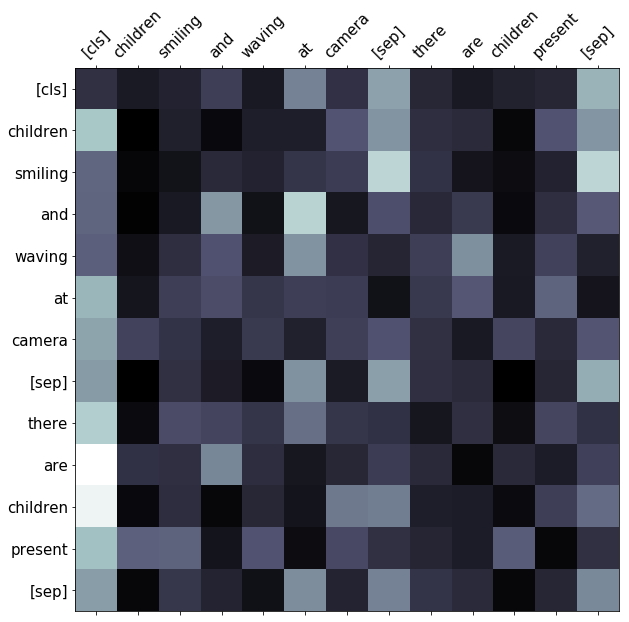

In [174]:
display_attention(4,bertmodel,0,0)

Affichons ensuite l'attention pour le dernier des entrainements, on voit clairement maintenant d'où l'attention venait

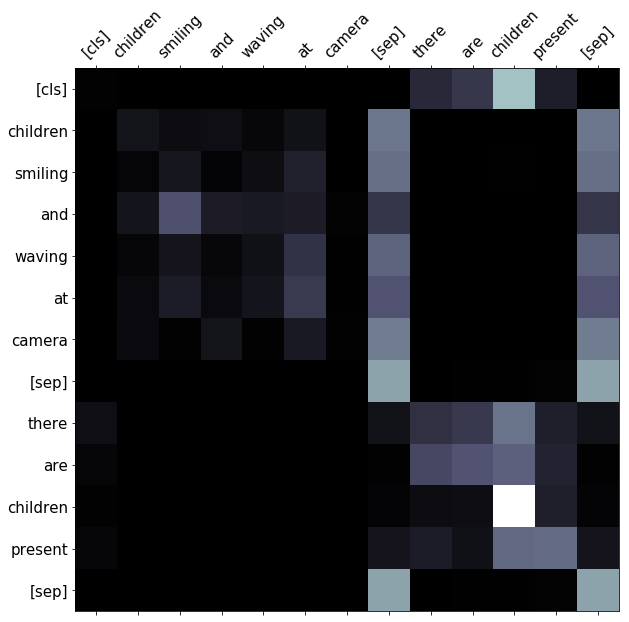

In [205]:
display_attention(4,bertmodel,nb1-1,nb2-2)

## Conclusion ##

Pendant ce TP, nous avons pu mettre en place un distilBERT afin de classifier la relation (Commune, Neutre et Contradictoire) entre deux phrases.

Notre modèle a obtenu une accuracy de 88%.

Nous pouvons aussi grace à la visualisation savoir d'où vient l'attention lors de la comparaison des relations.